# Instance Segmentation with Detectron2

## Setup

### Mount Google Drive

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
PATH = '/content/drive/My Drive/pandas-segmentation'
# os.makedirs(PATH, exist_ok = True)
os.chdir(PATH)

### Clone labelme2coco repo

In [ ]:
!git clone https://github.com/Tony607/labelme2coco.git

Cloning into 'labelme2coco'...
remote: Enumerating objects: 63, done.
remote: Total 63 (delta 0), reused 0 (delta 0), pack-reused 63
Unpacking objects: 100% (63/63), done.


In [ ]:
!pip install labelme

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 7.7MB 21.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 76.6MB 50kB/s 
     |████████████████████████████████| 286kB 37.0MB/s 
  Created wheel for imgviz: filename=imgviz-1.2.2-cp36-none-any.whl size=7673844 sha256=537366f1ca309832a829cce5f15a583f4f5ff00e11e9ef51cd64e41ce794d712
  Stored in directory: /root/.cache/pip/wheels/ec/a2/24/49c04d92128ca3f8fcb2a59b422b7a3e47fe660d82d4be13e0
Successfully built imgviz
  Created wheel for labelme: filename=labelme-4.5.6-cp36-none-any.whl size=1464599 sha256=e222f3d85bd4296de7128a15d0b06c3d1dbb22d839e593812b2fc3fb7089a012
  Stored in directory: /root/.cache/pip/wheels/10/a4/39/d225864c71769c24f9e41fc17e8e1f4a341a1191041a494dd4
Successfully built labelme


### Convert labelme file format to COCO data format

In [ ]:
!python labelme2coco/labelme2coco.py data/train --output=data/train.json
!python labelme2coco/labelme2coco.py data/test --output=data/test.json

save coco json
data/train.json
save coco json
data/test.json


### Install Detectron2 

In [3]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.7.0+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-twuz46m7
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-twuz46m7
     |████████████████████████████████| 276kB 4.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2-cp36-none-any.whl size=47718 sha256=09843e1c071070c7b2de363387f6e2372ca67e55bc49955b6f8a0b0257b513c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-k8lb361w/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=e889bad04ce60a5818144aeaaa6da5553543e51a906802683c746265bbd16798
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully

'1.6.0+cu101'

In [20]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/drive/My%20Drive/pandas-segmentation/detectron2_repo
     |████████████████████████████████| 2.2MB 9.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=1a9168026a6927e830daac3e773ce628c62c89064c07245e18cc293ddd55b9b4
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp36-cp36m-linux_x86_64.whl size=266514 sha256=d5455ee5fc0403b3f83db38a6f81372f654f65c8e32d821afff16b4b88df3dc6
  Stored in directory: /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e
Successfully built fvcore pycocotools
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: fvcore 0.1.1.post20200716 has requirement pyyaml>=5.1, but you'l

### Register dataset

Before continuing, restart the runtime of your Jupyter Notebook.

In [4]:
import os
import numpy as np
import json
# import detectron2
from detectron2.structures import BoxMode

In [5]:
import cv2
def get_image_dim(directory, json_file):
  imagename = json_file.replace('json', 'jpg')
  img = cv2.imread(imagename,)
  height, width = img.shape[:2]
  return height, width

In [6]:
def get_dataset_dicts(directory):
    classes = ['panda', 'red_panda']
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        height, width = get_image_dim(directory, json_file)
        record["height"] = height#600
        record["width"] = width#800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [46]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("pandasH_" + d, lambda d=d: get_dataset_dicts('data/' + d))
    MetadataCatalog.get("pandasH_" + d).set(thing_classes=['panda', 'red_panda'])

In [3]:
from detectron2.data import MetadataCatalog
dataset_metadata = MetadataCatalog.get("pandasH_train")

## Visualize dataset

In [7]:
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

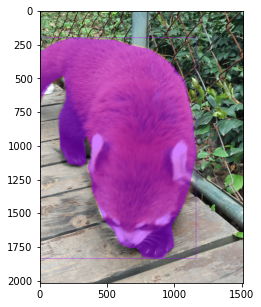

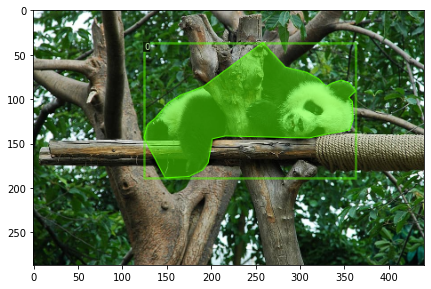

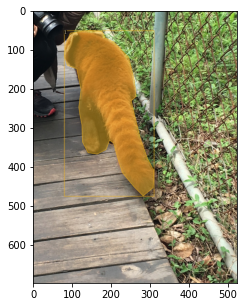

In [ ]:
dataset_dicts = get_dataset_dicts("data/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (7, 5))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


## Train model

In [48]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("pandasH_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/09 10:16:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[09/09 10:16:35 d2.engine.train_loop]: Starting training from iteration 0


/content/drive/My Drive/pandas-segmentation/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/drive/My Drive/pandas-segmentation/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/drive/My Drive/pandas-segmentation/detectron2_repo/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tup

[09/09 10:16:49 d2.utils.events]:  eta: 0:07:13  iter: 19  total_loss: 2.553  loss_cls: 1.168  loss_box_reg: 0.6881  loss_mask: 0.69  loss_rpn_cls: 0.003189  loss_rpn_loc: 0.006115  time: 0.5379  data_time: 0.3121  lr: 4.9953e-06  max_mem: 3237M
[09/09 10:17:02 d2.utils.events]:  eta: 0:08:20  iter: 39  total_loss: 2.434  loss_cls: 1.085  loss_box_reg: 0.6434  loss_mask: 0.6841  loss_rpn_cls: 0.004099  loss_rpn_loc: 0.007845  time: 0.5928  data_time: 0.3575  lr: 9.9902e-06  max_mem: 3292M
[09/09 10:17:13 d2.utils.events]:  eta: 0:07:57  iter: 59  total_loss: 2.126  loss_cls: 0.899  loss_box_reg: 0.5964  loss_mask: 0.6713  loss_rpn_cls: 0.003597  loss_rpn_loc: 0.005623  time: 0.5807  data_time: 0.2532  lr: 1.4985e-05  max_mem: 3343M
[09/09 10:17:25 d2.utils.events]:  eta: 0:08:06  iter: 79  total_loss: 2.156  loss_cls: 0.716  loss_box_reg: 0.737  loss_mask: 0.657  loss_rpn_cls: 0.003801  loss_rpn_loc: 0.007343  time: 0.5788  data_time: 0.2802  lr: 1.998e-05  max_mem: 3449M
[09/09 10:17:

## Predict on test set

In [ ]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("pandasH_test", )
predictor = DefaultPredictor(cfg)

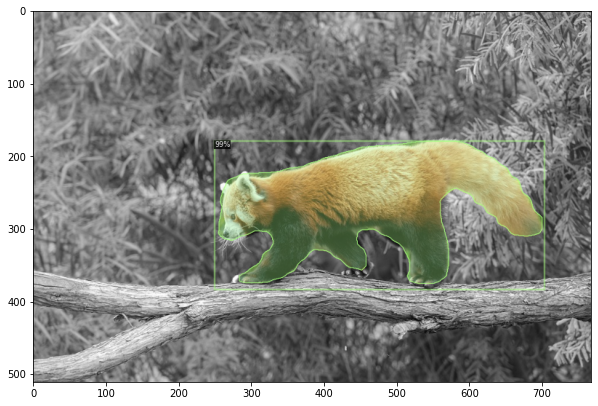

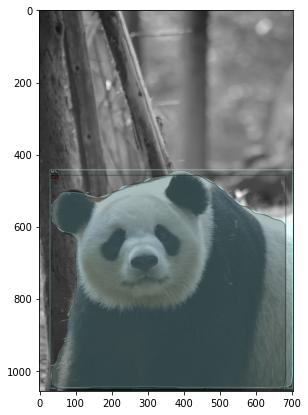

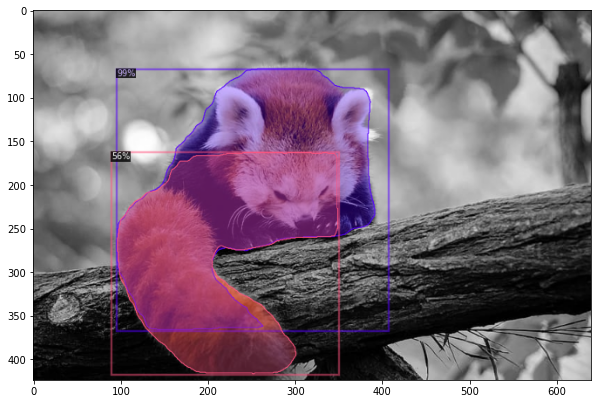

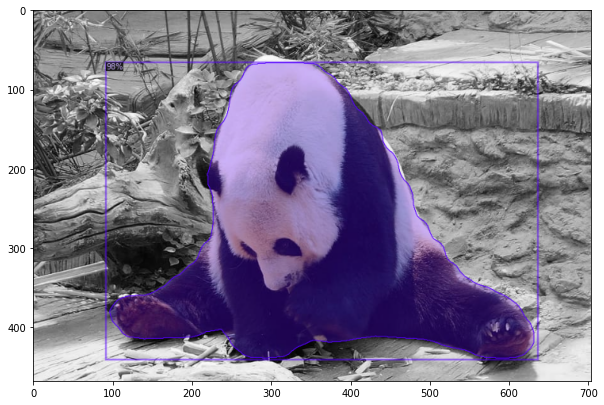

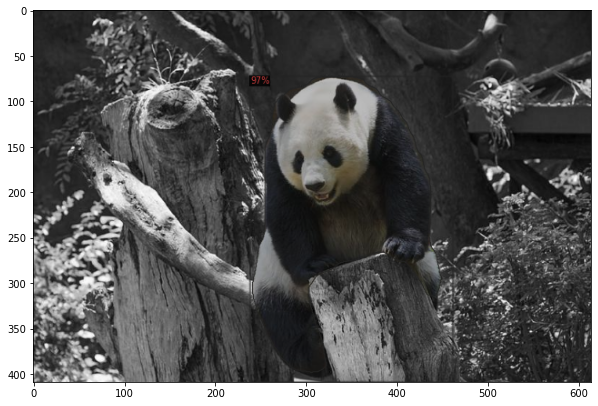

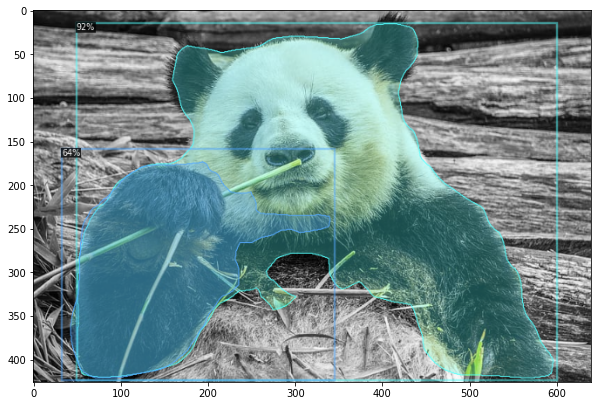

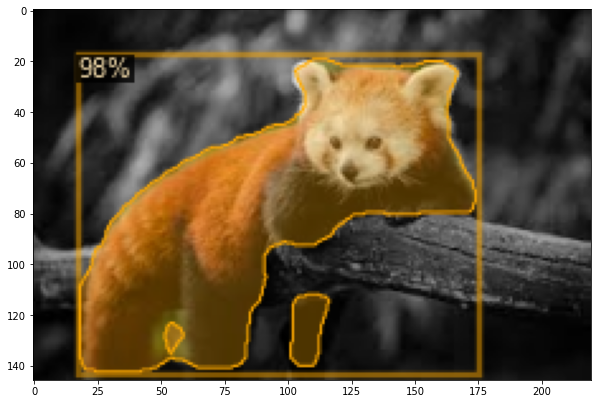

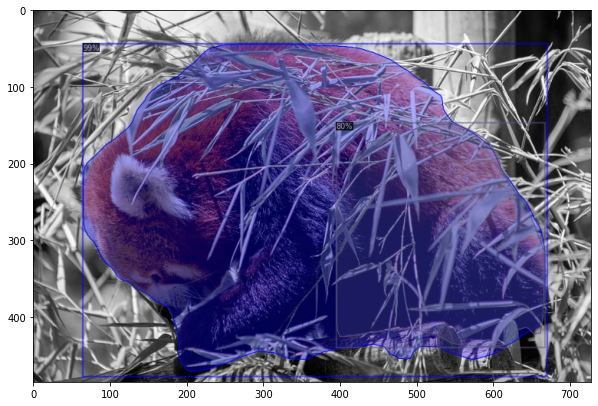

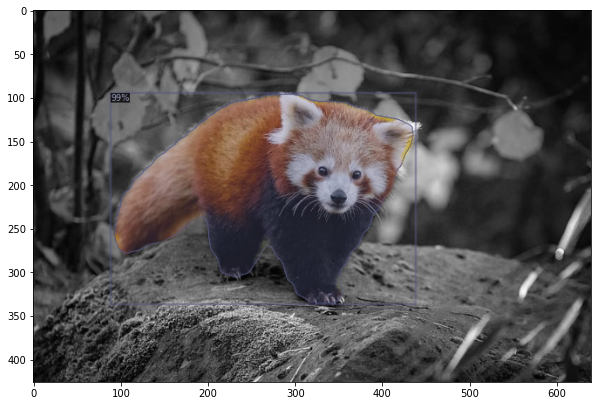

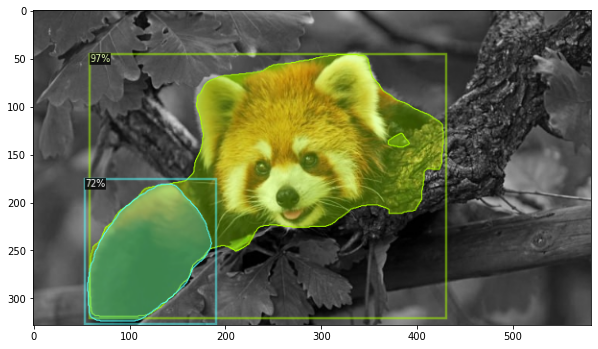

In [59]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dataset_dicts('data/test')
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (10, 7))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()